# REGCOIL-Like Coil Optimization in DESC

This notebook will show how to use DESC's REGCOIL implementation to find coils using the surface current optimization method, based off of [1]. We will find a coilset for the precise QA equilibrium by first finding a constant offset winding surface, then running the REGCOIL algorithm in two different ways to obtain the surface current which minimizes the quadratic flux on the plasma surface, and finally cutting that surface current into coils and checking the normal field error and field line tracing from that coilset to confirm the equilibrium surfaces are retained with the real coil field.

## REGCOIL Algorithm

The REGCOIL algorithm solves the following minimization problem

Follows algorithm of [1]_ to find the current potential Phi on the surface, given a surface current $\mathbf{K}$ from a surface current potential $\Phi$ on a winding surface:
$$\mathbf{K} =\mathbf{n} \times  \nabla \Phi $$
$$\Phi(\theta',\zeta') = \Phi_{sv}(\theta',\zeta') + \frac{G\zeta'}{2\pi} + \frac{I\theta'}{2\pi}$$
where the single valued part is given as a double Fourie series in the poloidal and toroidal angles:

$$\Phi_{SV}(\theta,\zeta) = \sum_{m,n} \Phi_{SV}^{mn} \mathcal{F}_m(\theta)\mathcal{F}_{nN_{FP}}(\zeta)$$
$$
\begin{align}
    \mathcal{F}_n(x) = \begin{cases} cos(|n|x) \text{for } n\geq 0 \\
    sin(|n|x) \text{for } n < 0 
    \end{cases}
\end{align}
$$
K = n x ∇ Φ
            Φ(θ,ζ) = Φₛᵥ(θ,ζ) + Gζ/2π + Iθ/2π

The algorithm minimizes the quadratic flux on the plasma surface due to the
surface current and external fields:

$$\min_{\Phi_{SV}^{mn}} ~\chi^2_B + \alpha \chi^2_K$$

where $\mathbf{B}\cdot\mathbf{n} = B_n$ and $\mathbf{n}$ is the unit surface normal on the plasma surface $S_{plasma}$, while 

$$\chi^2_B = \int_{S_{plasma}} (B_n)^2 dA$$

is the quadratic flux on the plasma boundary from the total magnetic field:

$$B_n = B_n^{SV}\{\Phi_{SV}\} + B_n^{GI} +B_n^{plasma} + B_n^{ext}$$

where the individual contributions to the normal field are the field from the single-valued surface current potential $B_n^{SV}$, the field from the secular part of the surface current potential $B_n^{GI}$, the field from the plasma currents $B_n^{plasma}$ and then any external fields $B_n^{ext}$ (e.g. a TF coilset or other coilset besides the winding surface). $G$ is fixed by the equilibrium magnetic field strength, and $I$ is determined by the desired coil topology (given by `current_helicity` in the `run_regcoil` method below), with zero corresponding to modular coils, and non-zero helicity corresponding to helical coils, according to the formula $I = -\frac{G}{ N_{FP} *(current\_helicity})$. The problem is regularized by the addition of a regularization parameter $\alpha$ multiplying the surface current magnitude integrated over the winding surface $S_{winding}$:

$$\chi^2_K = \int_{S_{winding}} |\mathbf{K}|^2 dA'$$

Smaller alpha corresponds to no regularization (consequently, lower Bn error but more complex and large surface currents) and larger alpha corresponds to more regularization (consequently, higher Bn error but simpler and smaller surface currents), which we will show shortly in this notebook.

[1] Landreman, An improved current potential method for fast computation of stellarator coil shapes, Nuclear Fusion (2017)

## imports

In [1]:
from desc import set_device
# set_device("gpu")
# uncomment above line if you are running on a GPU for a big speedup!
import numpy as np

from desc.equilibrium import  Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid
from desc.io import load
from desc.objectives import (
    FixParameter,
    ObjectiveFunction,
    QuadraticFlux,
    SurfaceCurrentRegularization
)
from desc.optimize import Optimizer
from scipy.constants import mu_0
from desc.magnetic_fields import FourierCurrentPotentialField

from desc.examples import get
from desc.plotting import *

DESC version 0.10.3+526.g74ab739ff.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 114.10 GB available memory


## Create Constant Offset Surface

We will use the algorithm outlined in the appendix of [1] to create a surface offset from the precise QA equilibrium surface by a constant distance of 0.2 meters. In DESC this is implemented as the `constant_offset_surface` method of `FourierRZToroidalSurface`, which will create a constant offset surface from the surface object it is called with by fitting a surface to points offset along the unit surface normal evaluated at a given grid on the base surface. We can thus use `eq.surface.constant_offset_surface(offset)` to obtain the desired surface.

In [2]:
eq = get("precise_QA")

# create the constant offset surface
surf = eq.surface.constant_offset_surface(offset=0.2, # desired offset
                                          M=16, # Poloidal resolution of desired offset surface
                                          N=8, # Toroidal resolution of desired offset surface
                                          grid=LinearGrid(M=32,N=16,NFP=eq.NFP)) # grid of points on base surface to evaluate unit normal and find points on offset surface,
                                                                                 # generally should be twice the desired resolution


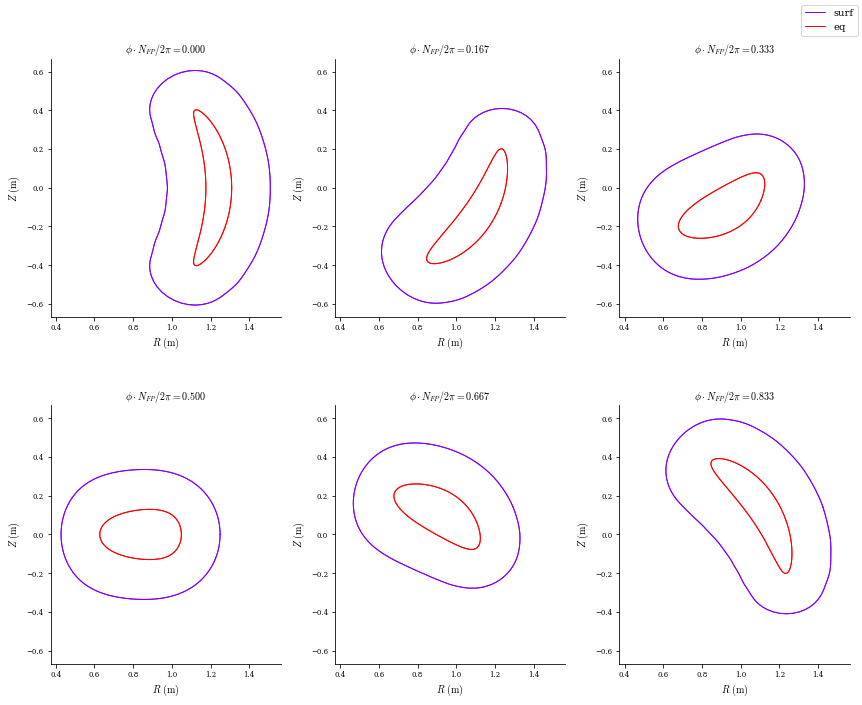

In [3]:
plot_comparison([surf,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0));

# REGCOIL Algorithm through `SurfaceCurrentField.run_regcoil` Method

To run the REGCOIL algorithm outlined earlier in this notebook, we can use the `FourierCurrentPotentialField` object in DESC, which describes a magnetic field created from a surface current of the form used in REGCOIL:
$$\mathbf{K} =\mathbf{n} \times  \nabla \Phi $$
$$\Phi(\theta',\zeta') = \Phi_{sv}(\theta',\zeta') + \frac{G\zeta'}{2\pi} + \frac{I\theta'}{2\pi}$$

where `FourierCurrentPotentialField.Phi_mn` corresponds to the Fourier coefficients of $\Phi_{sv}$, and `FourierCurrentPotentialField.I` and `FourierCurrentPotentialField.G` correspond to the net toroidal current on the surface $I$ and the net poloidal current on the surface $G$. $G$ is determined by the desired equilibrium field strength, and is manually assigned in this cell for clarity (in practice the `run_regcoil` method will automatically assign `G` according to the equilibrium field strength). We will show both modular $I=0$ and helical $I!=0$ coils in this notebook.

## Modular

Timer: Jacobian Calculation = 12.1 sec


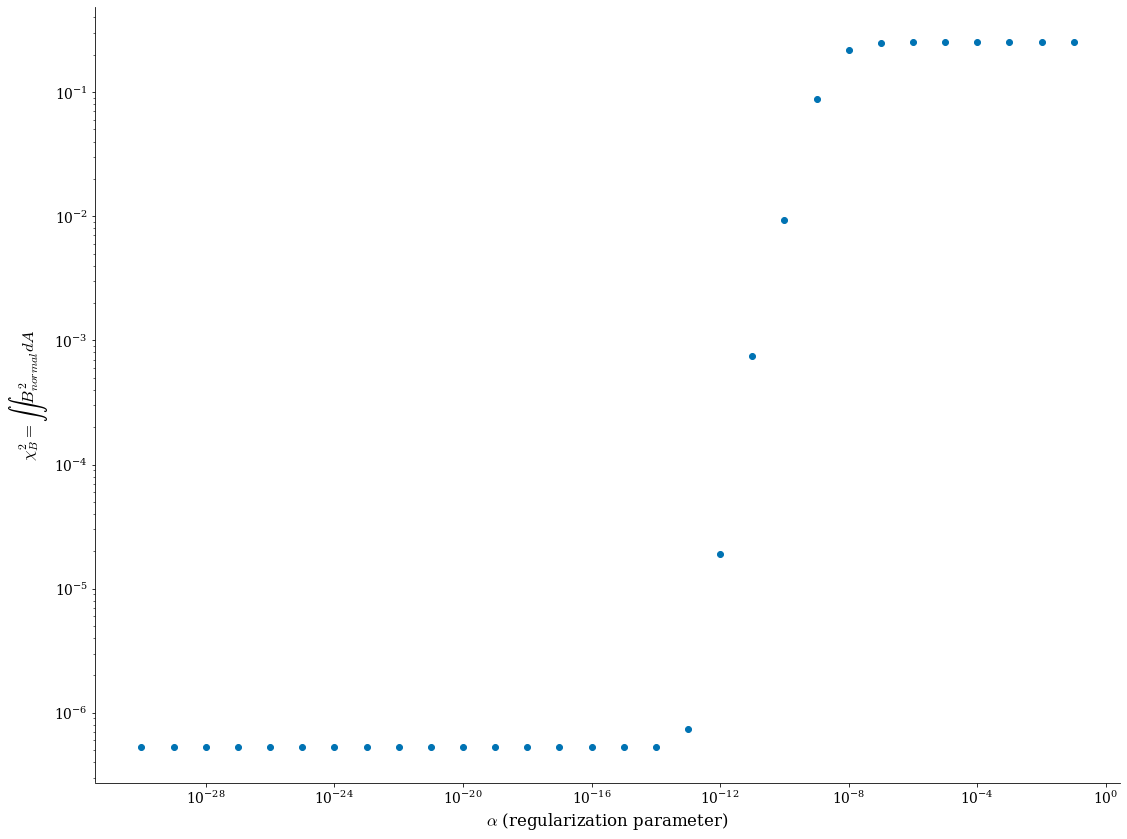

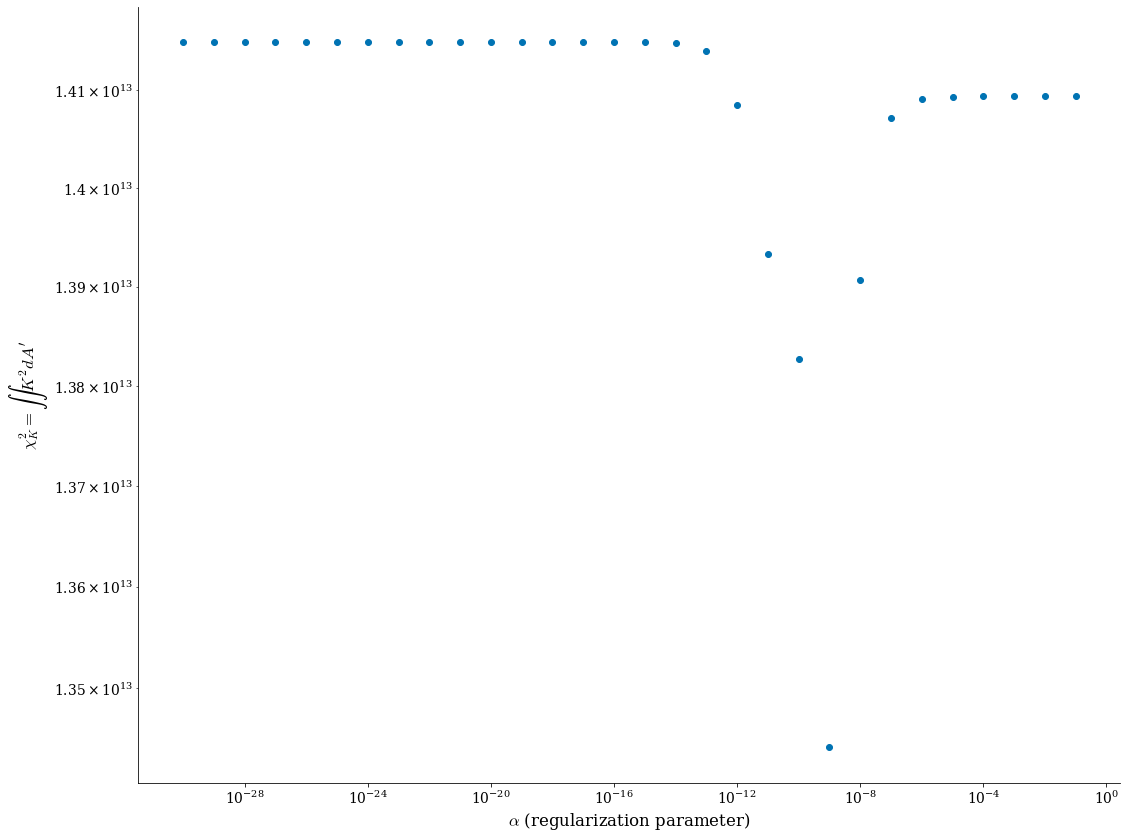

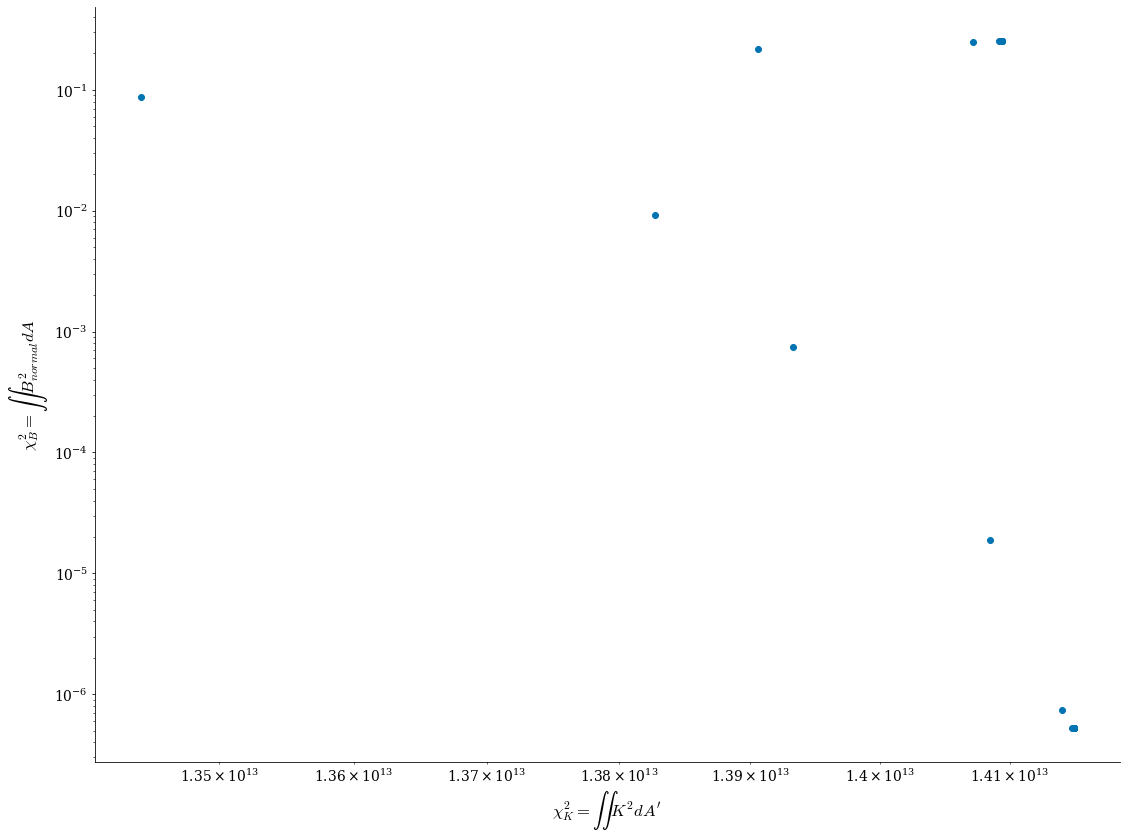

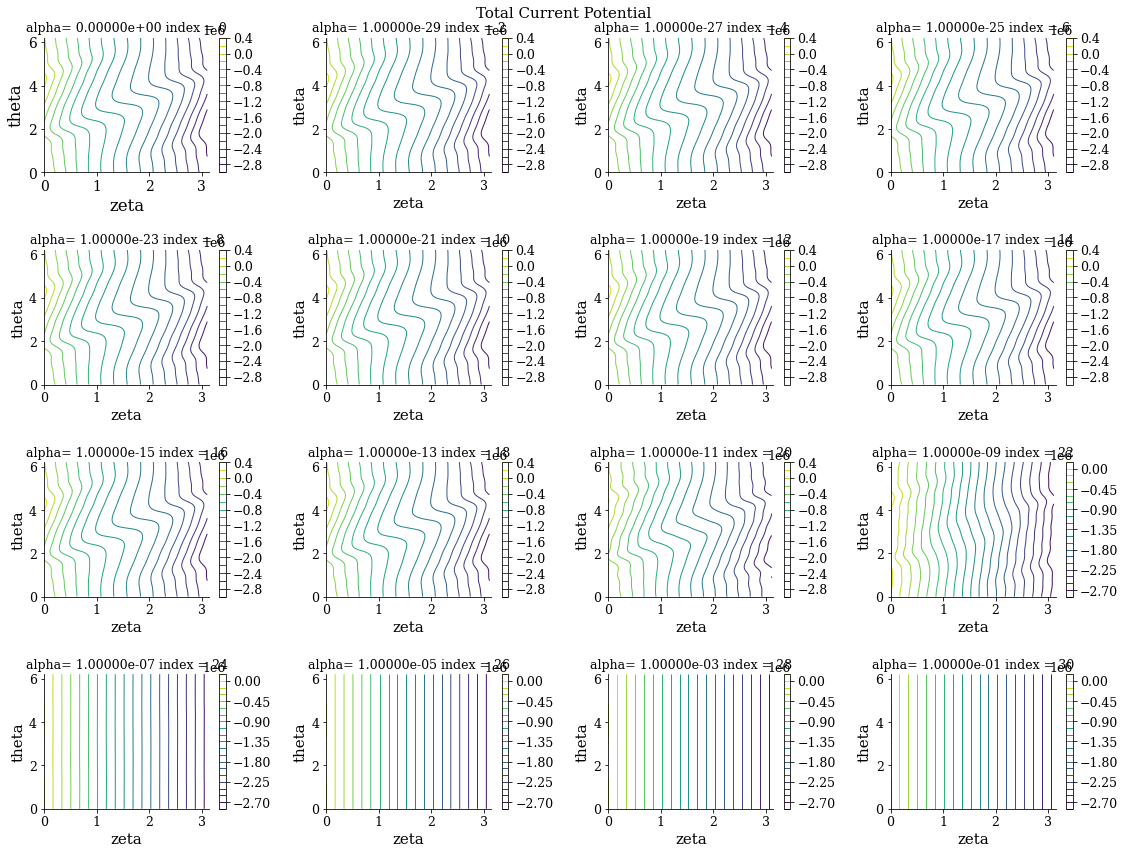

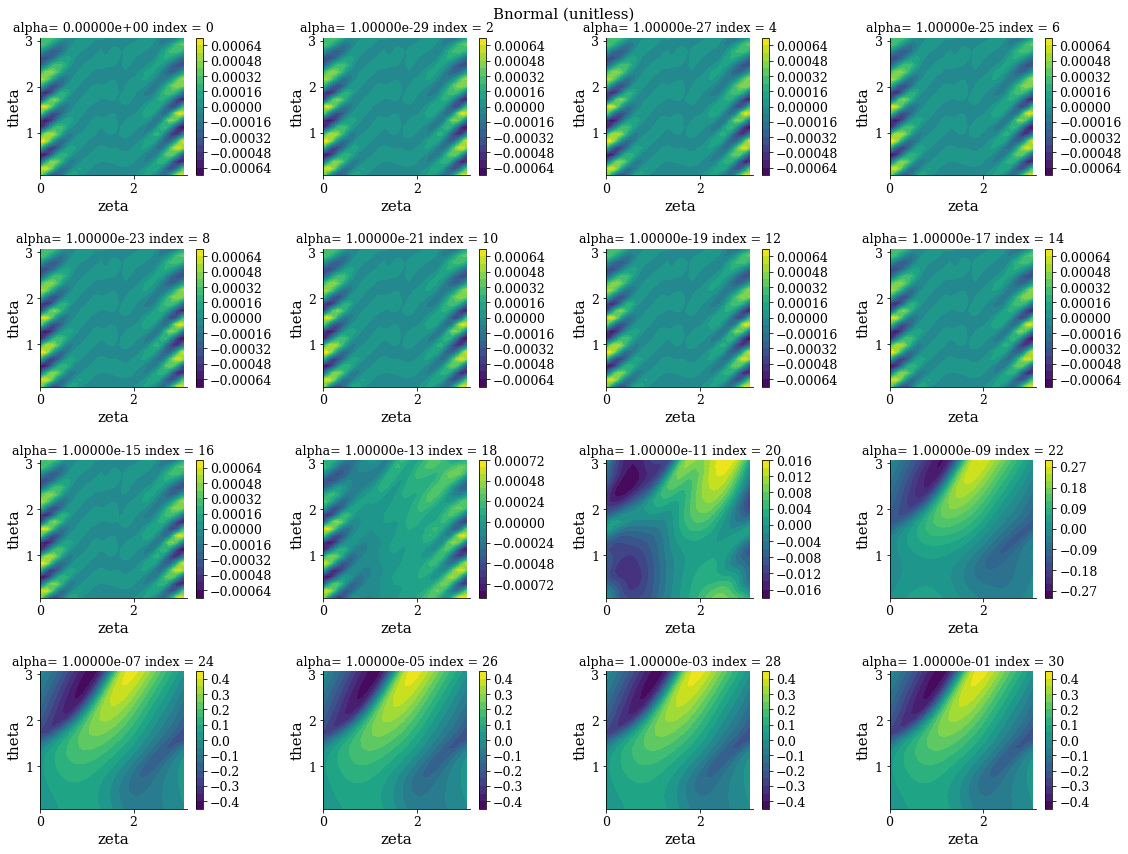

In [4]:
# create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
surface_current_field = FourierCurrentPotentialField.from_surface(surf,
                                                                  I=0,
                                                                  # manually setting G to value needed to provide the equilibrium's toroidal flux
                                                                  G=np.asarray([-eq.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0] / mu_0 * 2 * np.pi]), 
                                                                  # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
                                                                  sym_Phi="sin",)

# create the evaluation grid (where Bn will be minimized on plasma surface)
# and source grid (discretizes the source K for biot-savart and where |K| will be penalized on winding surface)
Megrid=20
Negrid=20
Msgrid=45
Nsgrid=45

eval_grid=LinearGrid(M=Megrid,N=Negrid,NFP=eq.NFP,sym=True)
# ensure that sym=False for source grid so the field evaluated from the surface current is accurate
# (i.e. must evalute source over whole surface, not just the symmetric part)
# NFP>1 is ok, as we internally will rotate the source through the field periods to sample entire winding surface
sgrid=LinearGrid(M=Msgrid,N=Nsgrid,NFP=eq.NFP,sym=False) 

# run_regcoil method runs the REGCOIL algorithm
data = surface_current_field.run_regcoil(eq=eq, # the Equilibrium object to minimize Bn on the surface of
                                         M_Phi=8, # the Poloidal resolution of the current potential Phi basis 
                                         N_Phi=8, # the Toroidal resolution of the current potential Phi basis
                                         source_grid=sgrid, # source grid
                                         eval_grid=eval_grid, # evaluation grid
                                         current_helicity=0, # integer, the ratio of G / (I*NFP), determines topology of contours,
                                         #  0 for modular (really is undefined, but we choose 0 to correspond to modular), !=0 for helical
                                         scan=True, # perform scan over the regularization parameter (which we call alpha) to see tradeoff between Bn and current complexity
                                         show_plots=True)


`data` is a dictionary containing the `Phi_mn` arrays for each different value of $\alpha$ (corresponding to the `data["alphas"]` item in the dict), as well as other useful information like the net currents $I$ and $G$ and the cost functions $\chi^2_B$ and $\chi^2_K$ at each value of $\alpha$

In [5]:
data.keys()

dict_keys(['fig_chi^2_B_vs_alpha', 'ax_chi^2_B_vs_alpha', 'fig_chi^2_K_vs_alpha', 'ax_chi^2_K_vs_alpha', 'fig_chi^2_B_vs_chi^2_K', 'ax_chi^2_B_vs_chi^2_K', 'fig_scan_Phi', 'ax_scan_Phi', 'fig_scan_Bn', 'ax_scan_Bn', 'alpha', 'Phi_mn', 'I', 'G', 'chi^2_B', 'chi^2_K', '|K|'])

## Helical

Timer: Jacobian Calculation = 21.5 sec


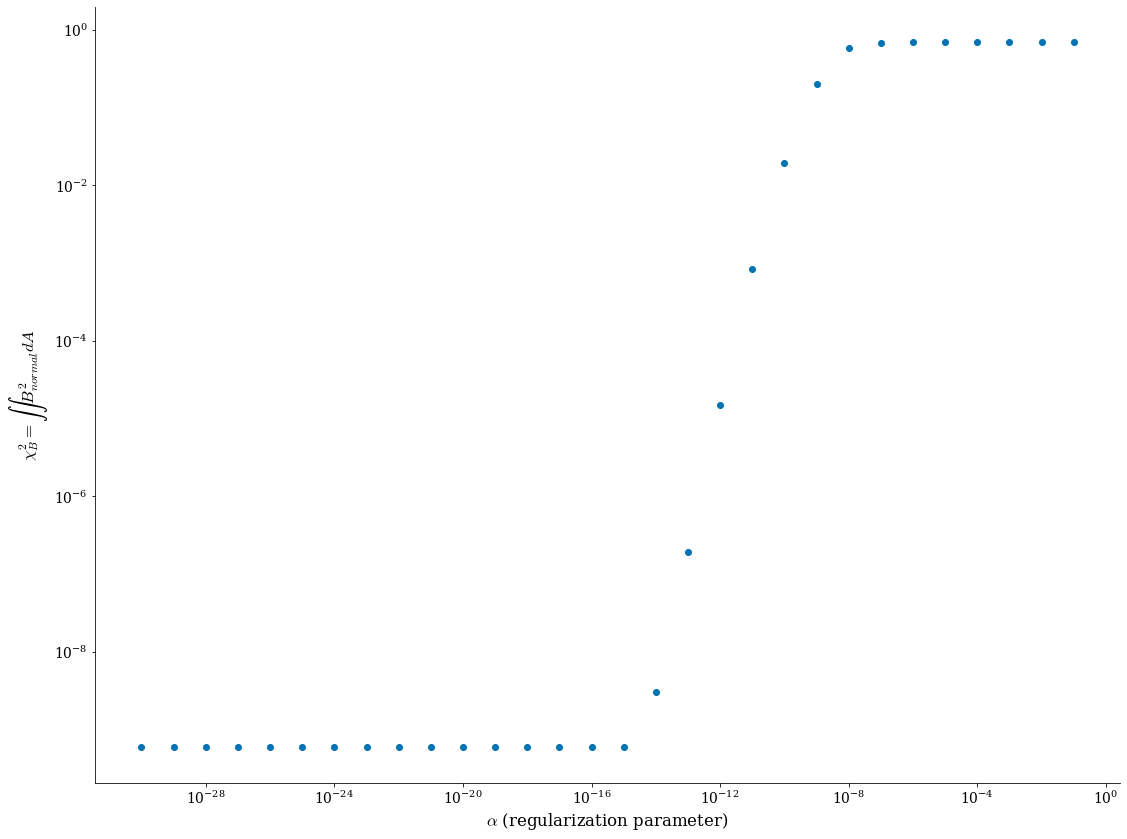

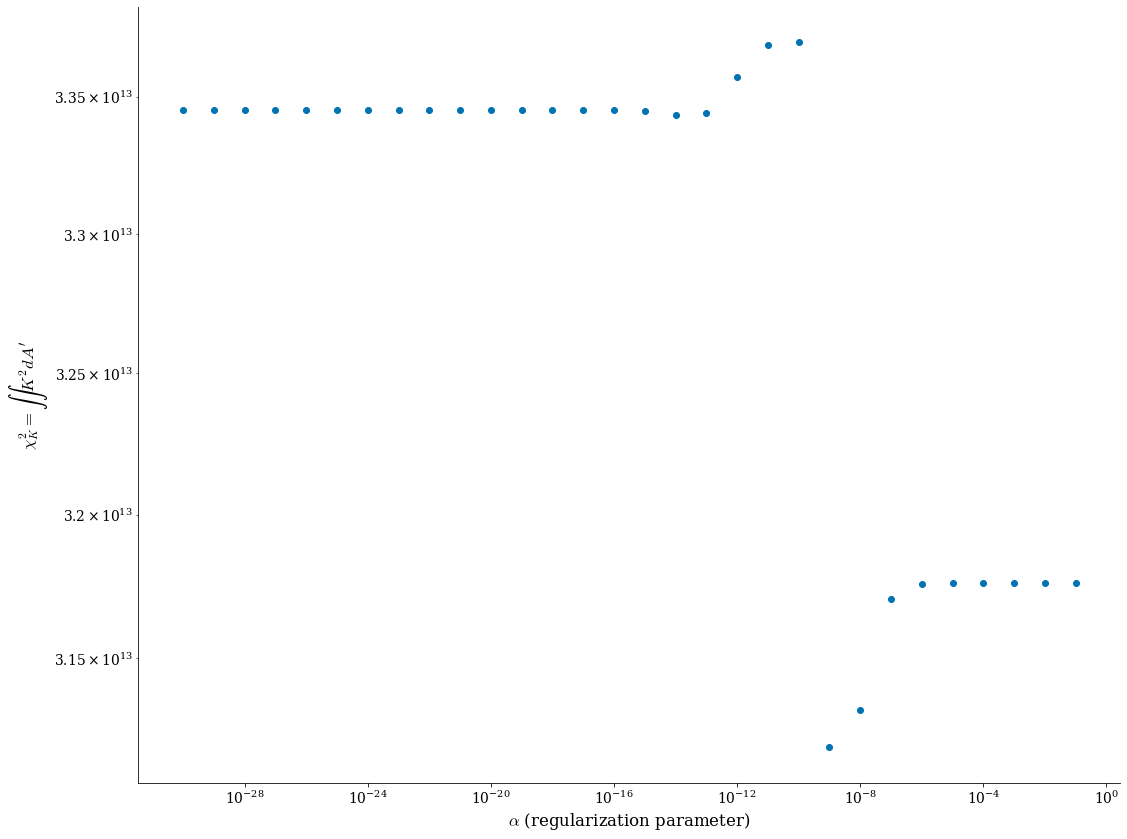

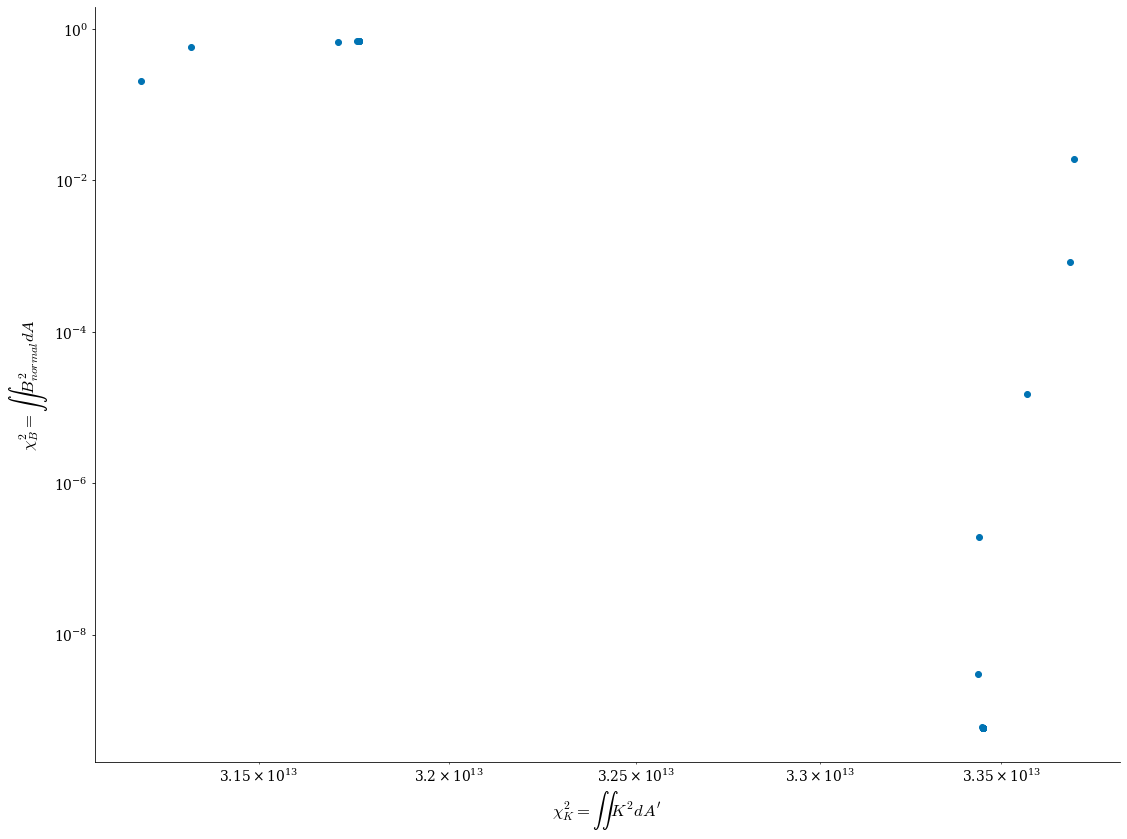

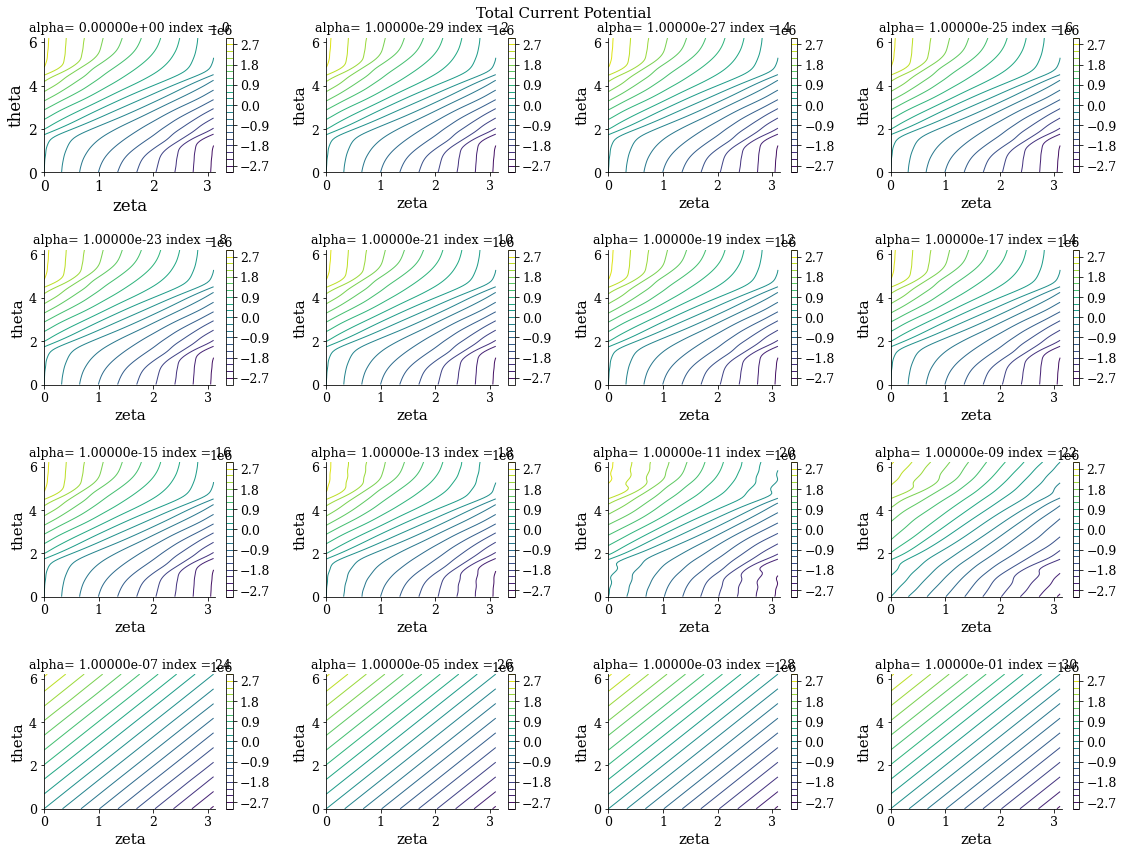

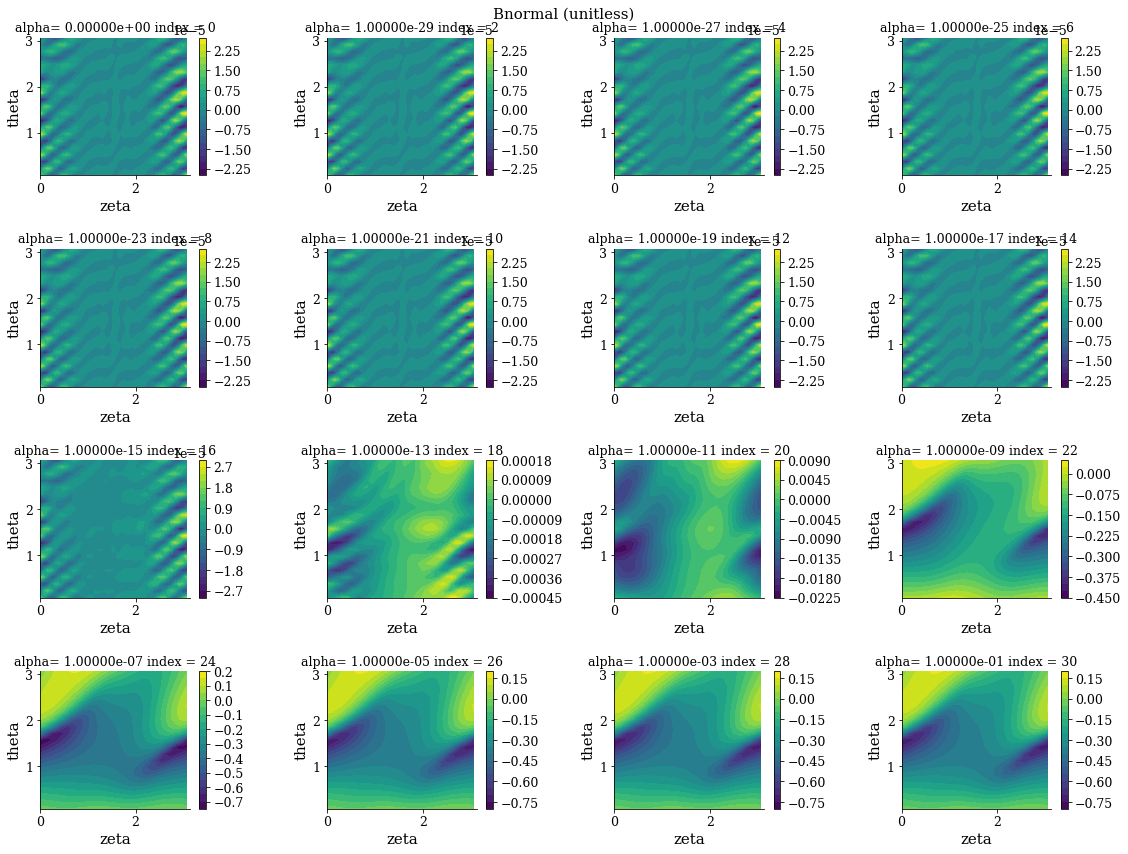

In [6]:
# create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
surface_current_field_helical = FourierCurrentPotentialField.from_surface(surf,
                                                                  I=0, # this will be overwritten with the `run_regcoil` call
                                                                  # manually setting G to value needed to provide the equilibrium's toroidal flux
                                                                  G=np.asarray([-eq.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0] / mu_0 * 2 * np.pi]), 
                                                                  # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
                                                                  sym_Phi="sin",)
# we use the same grids from the above cells

# run_regcoil method runs the REGCOIL algorithm
data_helical = surface_current_field_helical.run_regcoil(eq=eq, # the Equilibrium object to minimize Bn on the surface of
                                         M_Phi=12, # the Poloidal resolution of the current potential Phi basis 
                                         N_Phi=12, # the Toroidal resolution of the current potential Phi basis
                                         source_grid=sgrid, # source grid
                                         eval_grid=eval_grid, # evaluation grid
                                         current_helicity=-1, # integer, the ratio of G / (I*NFP), determines topology of contours,
                                         #  0 for modular, !=0 for helical, this is basically the number of poloidal transits per field period that a coil will make
                                         # the sign of the integer determines the slope of the contours, a negative integer corresponds to a slope dtheta/dzeta > 0
                                         scan=True, # perform scan over the regularization parameter (which we call alpha) to see tradeoff between Bn and current complexity
                                         show_plots=True)


From both of the above calculations, we can see that there is an optimal tradeoff between complexity and normal field error to be roughly $\alpha=1e-15$, so we will set the `surface_current_field` objects with the corresponding `Phi_mn`

In [7]:
# index 16 corresponds to alpha=~1e-15
surface_current_field.Phi_mn = data["Phi_mn"][16]
surface_current_field_helical.Phi_mn = data_helical["Phi_mn"][16]


# REGCOIL Algorithm with `QuadraticFlux`  and `SurfaceCurrentRegularization` Objective Functions

Alternatively, we can effectively do the same thing using the optimization framework of DESC, by using two objectives, a `QuadraticFlux` objective targeting the normal field errors on the plasma surface from the field, and a `SurfaceCurrentRegularization` objective to add the regularization based off of the surface current magnitude. This is basically the same problem as is solved above, but in a way that could be combined with other optimization objectives.

In [8]:
# form the constraints for the problem, we only want the Phi_mn to vary so we will fix all other parameters of FourierCurrentPotentialField
constraints = (# now fix all but Phi_mn
    FixParameter(surface_current_field,params=["I","G","R_lmn","Z_lmn"]),
)

Megrid=20
Negrid=20
Msgrid=40
Nsgrid=40
eval_grid=LinearGrid(M=Megrid,N=Negrid,NFP=eq.NFP,sym=True)
sgrid=LinearGrid(
                M=Msgrid,
                N=Nsgrid,
                NFP=eq.NFP,
            )
# we form the QuadraticFlux part of the objective function
obj_flux = QuadraticFlux(field=surface_current_field, # the field to be optimized
                         eq=eq,# the equilibrium upon which the quadratic flux is being evaluated
                         eval_grid=eval_grid,
                         source_grid = sgrid,
                         eq_fixed=True)
# the regularization cost based off of the surface current magnitude
obj_regularization = SurfaceCurrentRegularization(surface_current_field=surface_current_field,
                                                  source_grid = sgrid,
                                                   weight=1e-15)# we will set it to the optimal weight from above



optimizer = Optimizer("lsq-exact")

objective = ObjectiveFunction((obj_flux, obj_regularization))
(surface_current_field,), result = optimizer.optimize(
    surface_current_field, objective, constraints, verbose=1,
    ftol=0,
    gtol=0,
    xtol=1e-16,
    # because it is a linear least-squares problem, it is exactly solvable in 1 iteration
    maxiter=1,
    # we must make sure that the trust region of the optimization algorithm is
    # large enough to allow the entire problem to be solved in one step, so set the
    # trust radius to be infinite
    options={"initial_trust_radius":np.inf},
)


Building objective: quadratic-flux
Precomputing transforms
Building objective: surface-current-regularization
Precomputing transforms
Compiling objective function and derivatives: ['quadratic-flux', 'surface-current-regularization']
Number of parameters: 144
Number of objectives: 7422
Starting optimization
Using method: lsq-exact


/home/dpanici/DESC/desc/optimize/least_squares.py:330: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


         Current function value: 3.359e-05
         Total delta_x: 1.820e+01
         Iterations: 1
         Function evaluations: 2
         Jacobian evaluations: 2
Start of solver
Total (sum of squares):  3.359e-05, 
Maximum absolute Quadratic Flux:  7.441e-04 T
Minimum absolute Quadratic Flux:  1.566e-07 T
Average absolute Quadratic Flux:  1.269e-04 T
Maximum absolute Quadratic Flux:  7.441e-04 (normalized)
Minimum absolute Quadratic Flux:  1.566e-07 (normalized)
Average absolute Quadratic Flux:  1.269e-04 (normalized)
Maximum absolute Surface Current Regularization:  1.813e+06 
Minimum absolute Surface Current Regularization:  6.182e+05 
Average absolute Surface Current Regularization:  9.358e+05 
Maximum absolute Surface Current Regularization:  1.813e+06 (normalized)
Minimum absolute Surface Current Regularization:  6.182e+05 (normalized)
Average absolute Surface Current Regularization:  9.358e+05 (normalized)
Fixed parameter error:  0.000e+00 (~)
End of solver
Total (sum of squa

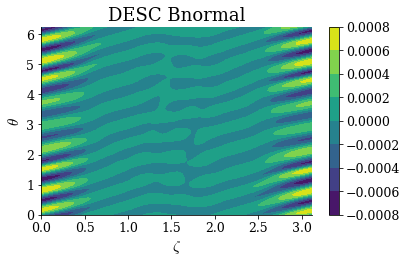

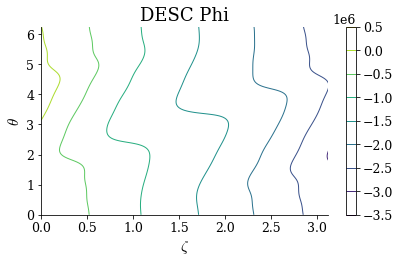

In [9]:
import matplotlib.pyplot as plt
grid = LinearGrid(M=80,N=80,NFP=eq.NFP)

Bn,_=surface_current_field.compute_Bnormal(eq.surface,eval_grid=grid,source_grid=grid)


Phi = surface_current_field.compute("Phi",grid=grid)["Phi"]

plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

plt.figure()
plt.contour(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Phi.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Phi")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()


# Create Coils from Surface Current

Now that we have the surface current, we can take a selection of constant $\Phi$ contours to discretize the surface current into coils. This can be done easily via the `FourierCurrentPotentialField.cut_surface_current_into_coils` method, which will take the surface current field and return a discretized coilset with the desired total number of coils `desirednumcoils`.

## Modular

In [10]:
coilset = surface_current_field.cut_surface_current_into_coils(desirednumcoils=14)# total number of coils desired 

We can compute the normal field error with the coilset now, we see it has increased from before since there is some discretization error from representing the continuous surface current with a discrete number of coils. Typically an average normal field error of about 1 percent (when normalized by the equilibrium field strength) is desired

Bn calc took 4.686e+00 seconds
normalized average <Bn> = 0.050668282952661035


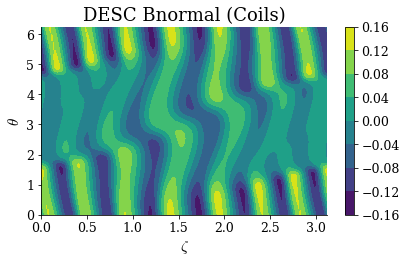

In [11]:
import time
t1=time.time()
Bn,_=coilset.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

print(f"normalized average <Bn> = {np.mean(np.abs(Bn) / eq.compute('|B|',grid=grid)['|B|'])}")

In [12]:
eq.compute('|B|',grid=grid)['|B|']

Array([0.93716429, 0.93727863, 0.93762137, ..., 0.93818481, 0.93761662,
       0.93727647], dtype=float64)

Bn calc took 1.198e+00 seconds


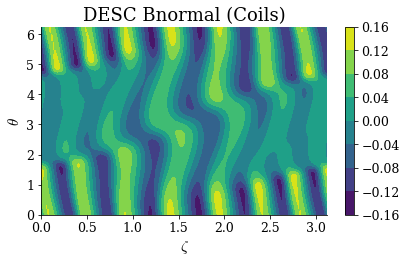

In [13]:
# fitting with a Fourier series will make the magnetic field computation more computationally efficient
cset = coilset.to_FourierXYZ(N=30) 
t1=time.time()
Bn,_=cset.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

In [14]:
# Field line integration (on a CPU this can take a few minutes)
from desc.magnetic_fields import field_line_integrate
ntransit = 200
r0 = np.linspace(1.16,1.25,20)
phis = np.arange(0, ntransit * 2 * np.pi + 1, 2 * np.pi)
t1 = time.time()
fieldR, fieldZ = field_line_integrate(
    r0=r0,
    z0=np.zeros_like(r0),
    phis=phis,
    field=cset,
)
print(f"field line integration took {time.time()-t1:1.3e} seconds")

field line integration took 5.289e+02 seconds


/home/dpanici/DESC/desc/utils.py:493: FutureWarning: argument zeta has been renamed to phi, zeta will be removed in a future release
  warnings.warn(


(-0.5, 0.5)

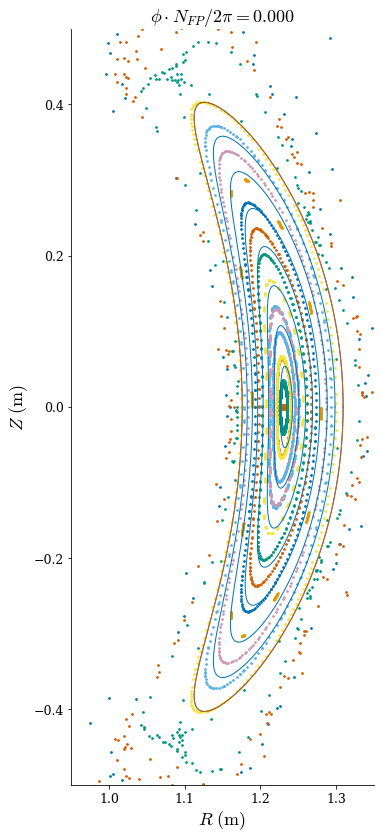

In [15]:
fig,ax = plot_surfaces(eq,zeta=np.array(0.0),theta=0,figsize=(12,12))
for i in range(fieldR.shape[1]):
    ax[0].scatter(fieldR[:,i],fieldZ[:,i],s=3)

plt.xlim([0.95,1.35])
plt.ylim([-0.5,0.5])


In [ ]:
# visualize by plotting coils
fig=plot_coils(cset)
fig.show()

## Helical

Helical coil cutting is just as easy as modular, with the same exact function call:

In [17]:
coilset_helical = surface_current_field_helical.cut_surface_current_into_coils(desirednumcoils=12)

Bn calc took 4.997e+00 seconds


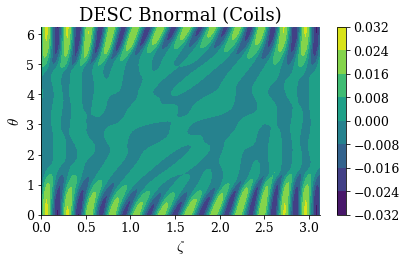

In [18]:
import time
t1=time.time()
Bn,_=coilset_helical.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

In [19]:
%pdb

Automatic pdb calling has been turned ON


Bn calc took 1.204e+00 seconds


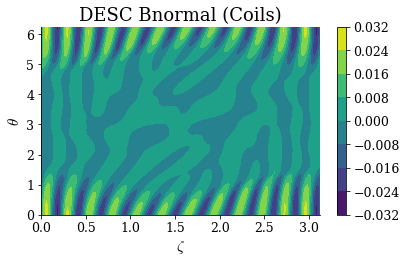

In [20]:
# fitting with a Fourier series will make the magnetic field computation more computationally efficient
cset_helical = coilset_helical.to_FourierXYZ(N=40) 
t1=time.time()
Bn,_=cset_helical.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

In [ ]:
# Field line integration (on a CPU this can take a few minutes)
from desc.magnetic_fields import field_line_integrate
ntransit = 200
r0 = np.linspace(1.16,1.25,20)
phis = np.arange(0, ntransit * 2 * np.pi + 1, 2 * np.pi)
t1 = time.time()
fieldR, fieldZ = field_line_integrate(
    r0=r0,
    z0=np.zeros_like(r0),
    phis=phis,
    field=cset_helical,
)
print(f"field line integration took {time.time()-t1:1.3e} seconds")

In [ ]:
fig,ax = plot_surfaces(eq,zeta=np.array(0.0),theta=0,figsize=(12,12))
ax[0].scatter(fieldR,fieldZ,s=3,c="r")

plt.xlim([0.95,1.35])
plt.ylim([-0.5,0.5])


In [ ]:
# visualize by plotting coils
fig=plot_coils(cset_helical)
fig.show()